In [90]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from scipy import stats
from scipy.special import boxcox, inv_boxcox

import warnings
warnings.filterwarnings('once')

In [91]:
df = pd.read_csv("../data/sephora_encoding.csv", index_col = 0)
df.head(1)

,brand,category,rating,number_of_reviews,love,price,online_only,exclusive,limited_edition,price_box,category_map,brand_encoding,online_only_No,online_only_Yes,exclusive_No,exclusive_Yes,limited_edition_No,limited_edition_Yes,rating_map
0,Acqua Di Parma,Fragrance,4.0,-0.215962,0.156305,66.0,Yes,No,No,8.343559,0,63,0,1,1,0,1,0,1


# Decision Tree XI

En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).

En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal. El objetivo de hoy es:

- Ajustar el modelo a un Decision Tree


In [92]:
# Separamos la variable respuesta de las variables predictoras.

X = df.drop(["price", "price_box", "brand", "category", "rating", "love", "online_only", "exclusive", "limited_edition"], axis = 1) 

# Solamente nos quedamos con la variable respuesta normalizada.

y = df["price_box"] 

In [93]:
# Dividimos los datos en train y test.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [94]:
# Ajustamos el modelo.

arbol = DecisionTreeRegressor(random_state =0)
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

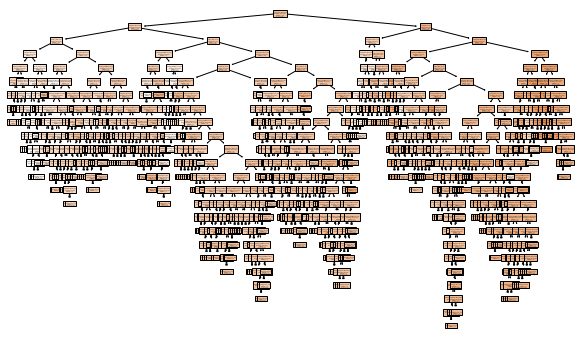

In [95]:
# Visualizamos nuestro árbol.

fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns.tolist(), filled = True);

- Extraer las métricas

Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas)

In [96]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    """
Esta función nos saca las métricas de nuestro modelo a predecir.
Args: 
    y_test(serie): los datos que tenemos.
    y_train(serie): los datos que ha predicho.
    y_test_pred(serie): los datos que tenemos.
    y_train_pred(serie): los datos que ha predicho.
    tipo_modelo(string): nombre que le damos a nuestro modelo.
Returns: devuelve un dataframe con las métricas.
    """   
    resultados = {"MAE": [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                "MSE": [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                "RMSE": [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                "R2":  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [97]:
# Realizamos las predicciones.

y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [98]:
# Sacamos los resultados.

df_resultados1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decision Tree I")
df_resultados1

,MAE,MSE,RMSE,R2,set,modelo
0,1.213786,3.567172,1.888696,0.167428,test,Decision Tree I
1,0.068053,0.128930,0.359068,0.967782,train,Decision Tree I


Con todos los datos que tenemos, se puede comprobar en las métricas que tenemos overfitting porque los resultados del train son mejores que los resultados del test. A continuación, vamos a ajustar esas métricas con los parámetros necesarios.

In [99]:
# Sacamos la raíz cuadrada del número de variables predictoras para poder establecer los hiperpámetros.

max_features = np.sqrt(len(x_train.columns))
max_features

3.1622776601683795

In [100]:
# Sacamos la máxima profundidad a la que puede llegar nuestro árbol.

arbol.tree_.max_depth

23

In [101]:
# Ajustamos los parámetros.

param = {"max_depth": [10,12,14,16], # tiene 23 de profundidad, no lo reducimos a la mitad porque no obteníamos buenos resultados.
        "max_features": [2,3,4,5,6], # la raíz cuadrada es 3, pero aumentamos para obtener buenos resultados.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [50,100,150],
        "min_samples_leaf": [50,100]}

In [102]:
# Una vez creado el diccionario iniciamos el modelo con GridSearch.

gs = GridSearchCV(
            estimator = DecisionTreeRegressor(), 
            param_grid = param,
            cv = 10, 
            verbose = 0, 
            return_train_score = True,            
scoring = "neg_mean_squared_error") 

In [103]:
# Ajustamos el modelo.

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 12, 14, 16],
                         'max_features': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [50, 100],
                         'min_samples_split': [50, 100, 150]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [104]:
# Sacamos el mejor modelo.

mejor_modelo = gs.best_estimator_ 
mejor_modelo

DecisionTreeRegressor(max_depth=14, max_features=6, min_samples_leaf=50,
                      min_samples_split=50)

In [105]:
# Realizamos las predicciones.

y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [106]:
# Obtenemos los resultados.

df_resultados2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
df_resultados2

,MAE,MSE,RMSE,R2,set,modelo
0,1.180196,2.550289,1.596962,0.404767,test,Decision tree II
1,1.106145,2.289711,1.513179,0.427825,train,Decision tree II


In [107]:
# Unimos los dos DataFrames con los resultados obtenidos.

dt_decision_results = pd.concat([df_resultados1, df_resultados2], axis = 0)
dt_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,1.213786,3.567172,1.888696,0.167428,test,Decision Tree I
1,0.068053,0.128930,0.359068,0.967782,train,Decision Tree I
0,1.180196,2.550289,1.596962,0.404767,test,Decision tree II
1,1.106145,2.289711,1.513179,0.427825,train,Decision tree II


Como podemos comprobar con las métricas obtenidas, nuestro modelo no es muy bueno, ya que no tiene muy buenas métricas. El R2 es muy bajo y el resto están bastante alejadas del 0. Aún así, solamente hay una diferencia de 3.5-3.8$, lo cual es relativamente bajo, teniendo en cuenta que nuestro mayor precio es 335$, mientras que nuestro precio mínimo es 14$. Además, nuestros resultados son peores en el train que en el test, aunque muy parecidos, lo cual nos indica que **no** estamos en un caso de *overfitting*.

# Random Forest XII

En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).

En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal y a un Decision Tree. El objetivo de hoy es:
- Ajustar el modelo a un Random Forest


In [108]:
# Como ya tenemos creado el diccionario con los parámetros, iniciamos el modelo con GridSearch.

gs_rf = GridSearchCV(
            estimator = RandomForestRegressor(), 
            param_grid = param, 
            cv = 10,  
            verbose = 0, 
            return_train_score = True, 
            scoring = "neg_mean_squared_error") 

In [109]:
# Ajustamos el modelo.

gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 12, 14, 16],
                         'max_features': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [50, 100],
                         'min_samples_split': [50, 100, 150]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [110]:
# Sacamos el mejor modelo.

bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=14, max_features=6, min_samples_leaf=50,
                      min_samples_split=100)

  0%|          | 0/100 [00:00<?, ?it/s]

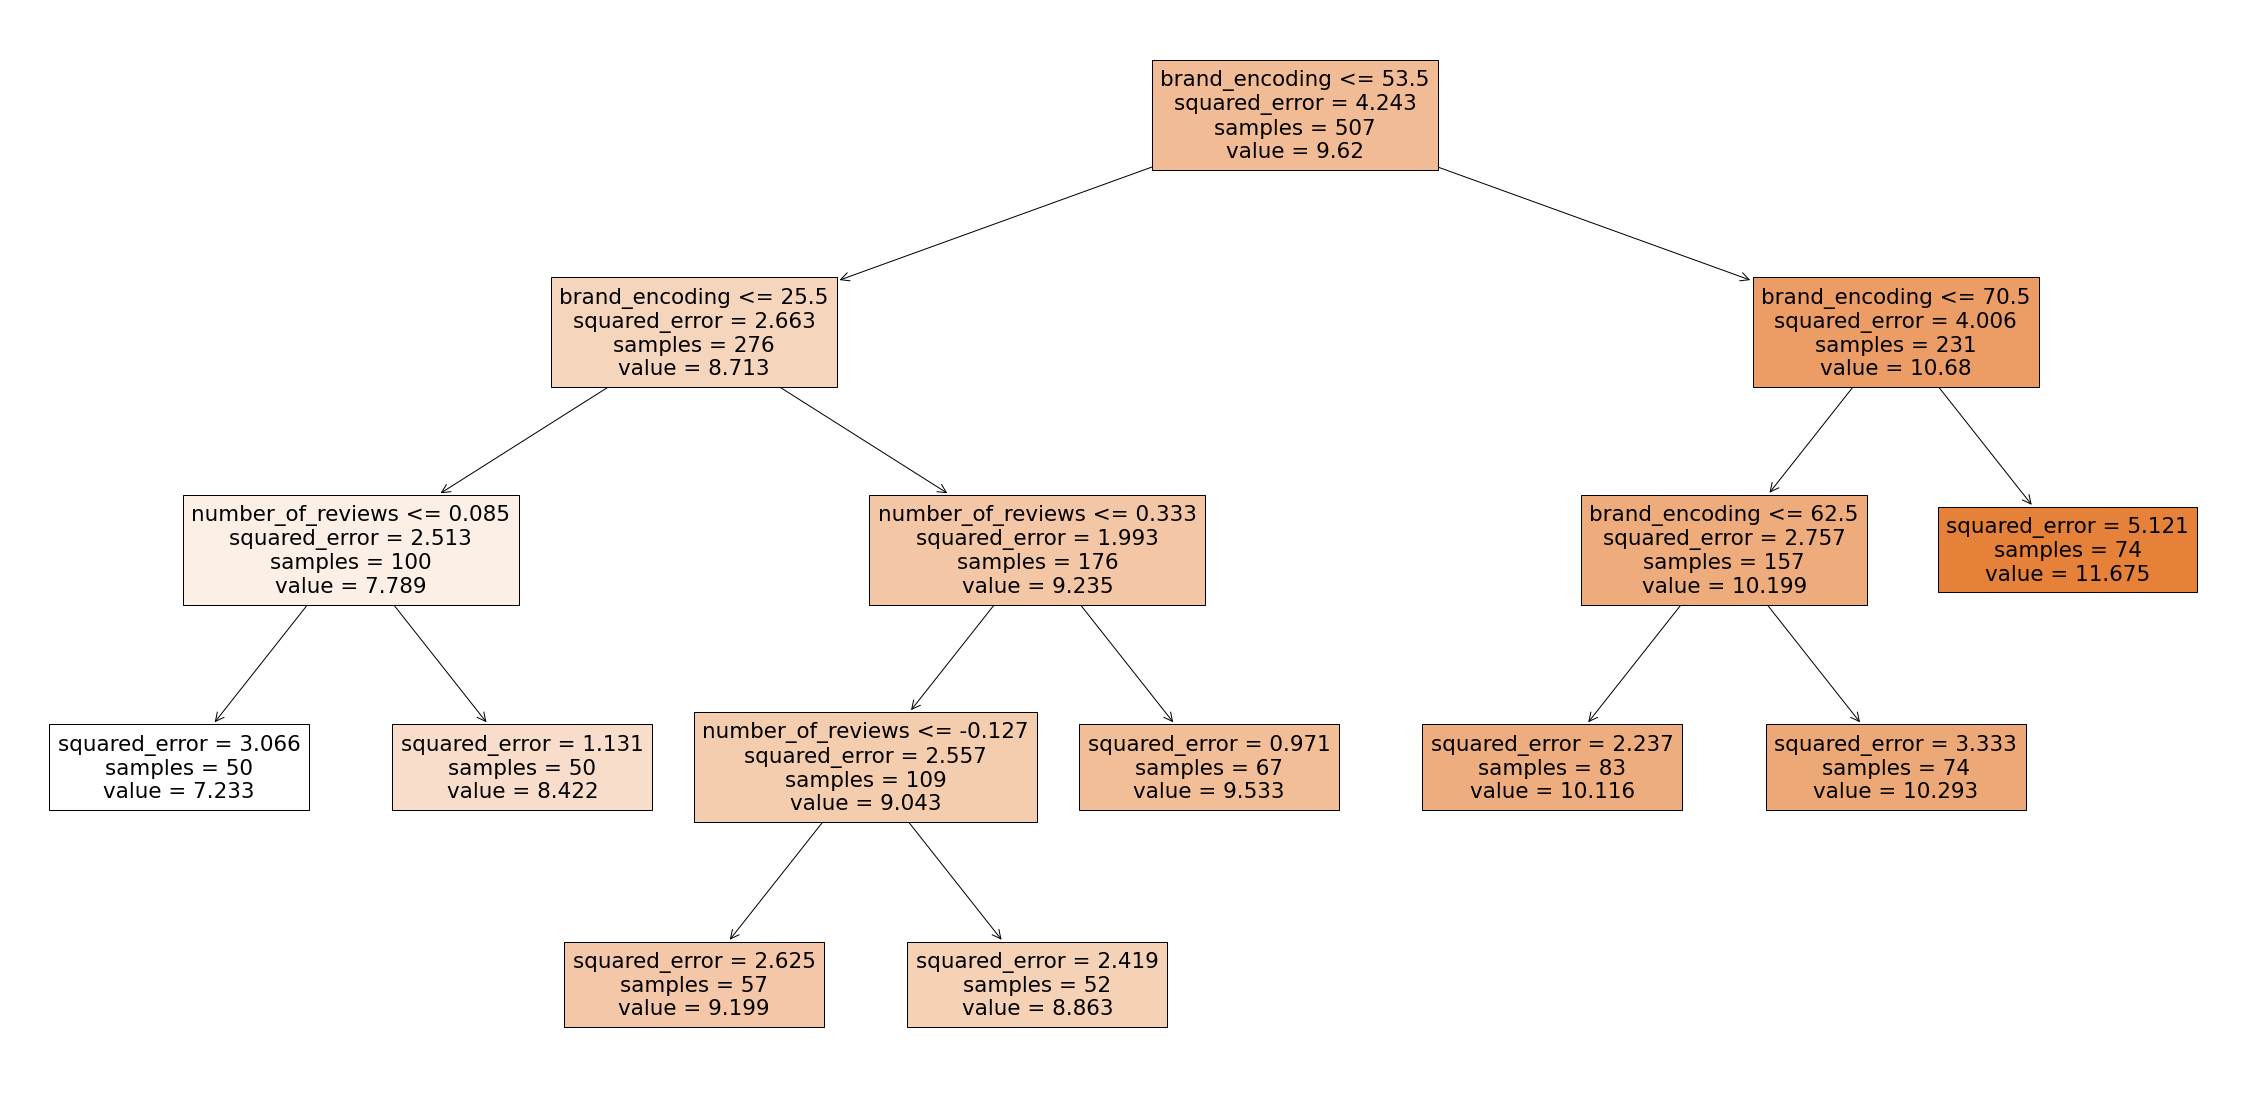

  0%|          | 0/100 [00:02<?, ?it/s]


In [111]:
# Sacamos un único árbol porque sacar todo el bosque consume muchos recursos.

for arbol in tqdm(bosque.estimators_):
    fig = plt.figure(figsize = (40, 20))
    tree.plot_tree(arbol, feature_names= x_train.columns.tolist(), filled = True)
    plt.show()
    break

In [112]:
# Entrenamos el modelo.

y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

- Extraer las métricas

Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas).

In [113]:
# Sacamos las métricas.

df_resultados3 = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest I")
df_resultados3

,MAE,MSE,RMSE,R2,set,modelo
0,1.100415,2.504414,1.582534,0.415474,test,Random Forest I
1,1.087124,2.281427,1.510439,0.429895,train,Random Forest I


In [114]:
df_metricas.to_csv("../data/metricas_finales.csv")

In [115]:
# Sacamos la importancia de nuestros predictores.

importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                            'importancia': bosque.feature_importances_}
                            )

importancia_predictores.sort_values(by = ["importancia"], ascending = False, inplace = True)

print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
2,brand_encoding,0.801380
1,category_map,0.099431
5,exclusive_No,0.034243
0,number_of_reviews,0.025437
6,exclusive_Yes,0.025259
7,limited_edition_No,0.005254
8,limited_edition_Yes,0.005141
4,online_only_Yes,0.003539
3,online_only_No,0.000315
9,rating_map,0.000000


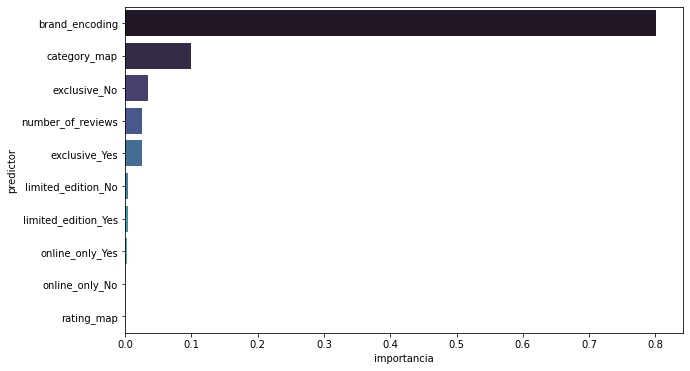

In [116]:
# Lo comprobamos visualmente.

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette = "mako");
plt.show()

In [118]:
# DataFrame con los predictores.

importancia_predictores

,predictor,importancia
2,brand_encoding,0.801380
1,category_map,0.099431
5,exclusive_No,0.034243
0,number_of_reviews,0.025437
6,exclusive_Yes,0.025259
7,limited_edition_No,0.005254
8,limited_edition_Yes,0.005141
4,online_only_Yes,0.003539
3,online_only_No,0.000315
9,rating_map,0.000000


### Segundo modelo:

Intentamos mejorar las métricas del Random Forest.

In [119]:
# Ajustamos los parámetros.

param2 = {"max_depth": [14,15,16], # tiene 23 de profundidad, no lo reducimos a la mitad porque no obteníamos buenos resultados.
        "max_features": [4,5,6,7], # la raíz cuadrada es 3, pero aumentamos para obtener buenos resultados.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [5,10],
        "min_samples_leaf": [5,10,20]}

In [120]:
# Como ya tenemos creado el diccionario con los parámetros, iniciamos el modelo con GridSearch.

gs_rf2 = GridSearchCV(
            estimator = RandomForestRegressor(), 
            param_grid = param2, 
            cv = 10,  
            verbose = 0, 
            return_train_score = True, 
            scoring = "neg_mean_squared_error")

In [121]:
# Ajustamos el modelo.

gs_rf2.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [14, 15, 16],
                         'max_features': [4, 5, 6, 7],
                         'min_samples_leaf': [5, 10, 20],
                         'min_samples_split': [5, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [122]:
# Sacamos el mejor modelo.

bosque2 = gs_rf2.best_estimator_
bosque2

RandomForestRegressor(max_depth=15, max_features=7, min_samples_leaf=5,
                      min_samples_split=5)

In [123]:
# Entrenamos el modelo.

y_pred_test_rf2 = bosque2.predict(x_test)
y_pred_train_rf2 = bosque2.predict(x_train)

In [124]:
df_resultados4 = metricas(y_test, y_train, y_pred_test_rf2, y_pred_train_rf2, "Random Forest II")
df_resultados4

,MAE,MSE,RMSE,R2,set,modelo
0,0.991842,1.922032,1.386374,0.551401,test,Random Forest II
1,0.790492,1.258405,1.121786,0.685538,train,Random Forest II


In [128]:
# Sacamos los resultados y los unimos.

df2 = pd.read_csv("../data/resultados_metricas.csv", index_col = 0)

df_metricas = pd.concat([df2, df_resultados1, df_resultados2, df_resultados3, df_resultados4], axis = 0)
df_metricas

,MAE,MSE,RMSE,R2,set,modelo
0,1.048010,2.187337,1.478965,0.489479,test,Linear Regresion
1,1.062521,2.169731,1.473001,0.457807,train,Linear Regresion
0,1.213786,3.567172,1.888696,0.167428,test,Decision Tree I
1,0.068053,0.128930,0.359068,0.967782,train,Decision Tree I
0,1.180196,2.550289,1.596962,0.404767,test,Decision tree II
1,1.106145,2.289711,1.513179,0.427825,train,Decision tree II
0,1.100415,2.504414,1.582534,0.415474,test,Random Forest I
1,1.087124,2.281427,1.510439,0.429895,train,Random Forest I
0,0.991842,1.922032,1.386374,0.551401,test,Random Forest II
1,0.790492,1.258405,1.121786,0.685538,train,Random Forest II


In [126]:
df["price_box3"], lambda_ajustada = stats.boxcox(df["price"])

In [127]:
inv_boxcox(df_resultados4["RMSE"], lambda_ajustada)

0    3.190994
1    2.631901
Name: RMSE, dtype: float64

### Conclusiones finales:

A modo de conclusión, podemos ver nuestro mejor modelo se ha realizado con nuestro algoritmo de regresión lineal, pero nuestros datos no cumplen las tres asunciones. Por lo tanto, el que se ha realizado con el algoritmo de **Random Forest** será más apropiado. No obstante, las métricas no son buenas. Podemos ver que la marca influye mucho a la hora de concluir el precio, mientras que el resto de categorías no influyen apenas. 

Para realizar este modelo hemos incluido casi todas las variables disponibles. Para el futuro, podríamos realizar el modelo con la variable predictora de "size", ya que la eliminamos en un primer momento al tener demasiadas opciones disponibles. Además, también podría realizarse un modelo contando con los ingredientes del producto, ya que éstos podrían influir a la hora de poner un precio. Por último, sería interesante incluir otro tipo de variables que no aparecen en nuestro dataset, como por ejemplo: el número de ventas; el género, a quién va dirigido el producto; tipo de promoción/marketing realizado, es decir, si ha tenido una campaña de marketing intensa o no; qué tipo de etiqueta tienen en la web (hemos visto que hay etiquetas como "productos icónicos", "novedad", "good for", "novedades"); las "reviews" desglosadas, ver cuántas reseñas de 5 tiene, cuántas de 4; etc. Además, otras opciones que se nos ocurren, aunque no están directamente relacionadas con Sephora, serían si este producto lo ha promocionado un influencer o no, si es viral en TikTok o YouTube...  